# Semantic Segmentation and Object Detection

## Agenda
1. Segmentation with U-Net on the CARVANA dataset
2. Detection metrics and models
3. Object detection with FasteRCNN on the PennFudan dataset

In [ ]:
!wget https://www.dropbox.com/s/tc1qo73rrm3gt3m/CARVANA.zip  # Carvana dataset
!wget https://www.dropbox.com/s/k886cusbuc1afnq/imagenet-mini.zip  # mini image-net dataset
!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt  # Classes of ImageNet
!unzip -q CARVANA.zip
!unzip -q imagenet-mini.zip
!rm -rf ./train/.DS_Store
!rm -rf ./train_masks/.DS_Store
!pip install colour

--2023-12-01 15:22:33--  https://www.dropbox.com/s/tc1qo73rrm3gt3m/CARVANA.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tc1qo73rrm3gt3m/CARVANA.zip [following]
--2023-12-01 15:22:33--  https://www.dropbox.com/s/raw/tc1qo73rrm3gt3m/CARVANA.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6dd93abf9ff04e3e222f995a15.dl.dropboxusercontent.com/cd/0/inline/CIl5E_ua5NTL-x3r-YK-v0fr55d7kjIVe3encvXbU6FOSWVn9jnvxQS6zBtsBncAP-3qle8yy-zVzIH3yDmGs7AtJ7qEepC-_m6IrNN-wONFOfR0cAcCpFzRyqKEeK6c7rgCuAicltS32TFvNOiwEjl1/file# [following]
--2023-12-01 15:22:34--  https://uc6dd93abf9ff04e3e222f995a15.dl.dropboxusercontent.com/cd/0/inline/CIl5E_ua5NTL-x3r-YK-v0fr55d7kjIVe3encvXbU6FOSWVn9jnvxQS6zBtsBncAP-3qle8yy-zVzIH3yDmGs7AtJ7qEepC-_m6IrNN-w

# 1. Semantic Segmentation

https://arxiv.org/abs/1604.01685

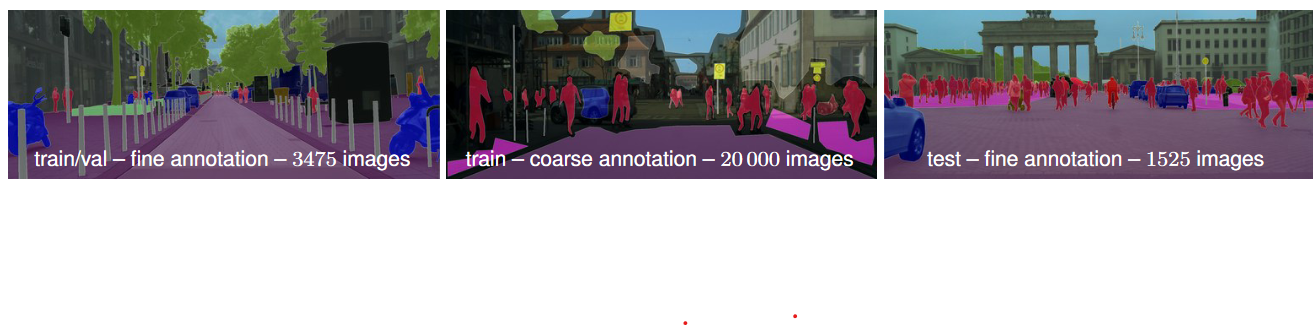

In [ ]:
import os
import warnings
from os.path import isfile, join
from typing import Dict, List, Tuple, Union

#import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from colour import Color
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm, trange

warnings.filterwarnings("ignore")

In [ ]:
class Carvana(Dataset):
    def __init__(
        self,
        root: str,
        transform: transforms.Compose = None,
    ) -> None:
        """
        :param root: path to the root folder
        :param transform: transforms of the images and labels
        """
        self.root = os.path.expanduser(root)
        self.transform = transform
        (self.data_path, self.labels_path) = ([], [])

        def load_images(path: str) -> List[str]:
            """
            :param path: path to data
            :return: the list with paths to the images
            """
            images_dir = [
                join(path, f) for f in os.listdir(path) if isfile(join(path, f))
            ]
            images_dir.sort()

            return images_dir

        self.data_path = load_images(self.root + "/train")
        self.labels_path = load_images(self.root + "/train_masks")

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        :param index: sample index
        :return: tuple (img, target) with the input data and its label
        """
        img = Image.open(self.data_path[index])
        target = Image.open(self.labels_path[index])

        if self.transform is not None:
            img = self.transform(img)
            target = self.transform(target)
            target = (target > 0).float()

        return (img, target)

    def __len__(self):
        return len(self.data_path)


def im_show(img_list: List[Tuple[str, str]]) -> None:
    """
    Plots images with correspinding segmentation mask

    :param img_list: list of paths to images
    """

    to_PIL = transforms.ToPILImage()
    if len(img_list) > 9:
        raise Exception("len(img_list) must be smaller than 10")

    fig, axes = plt.subplots(len(img_list), 2, figsize=(16, 16))
    fig.tight_layout()

    for (idx, sample) in enumerate(img_list):
        a = axes[idx][0].imshow(np.array(to_PIL(sample[0])))
        b = axes[idx][1].imshow(np.array(to_PIL(sample[1])), cmap='gray')
        for ax in axes[idx]:
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
train_dataset = Carvana(
    root=".",
    transform=transforms.Compose(
        [transforms.Resize((256, 256)), transforms.ToTensor()]
    ),
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=2
)

In [ ]:
train_dataset[0][1].shape

torch.Size([1, 256, 256])

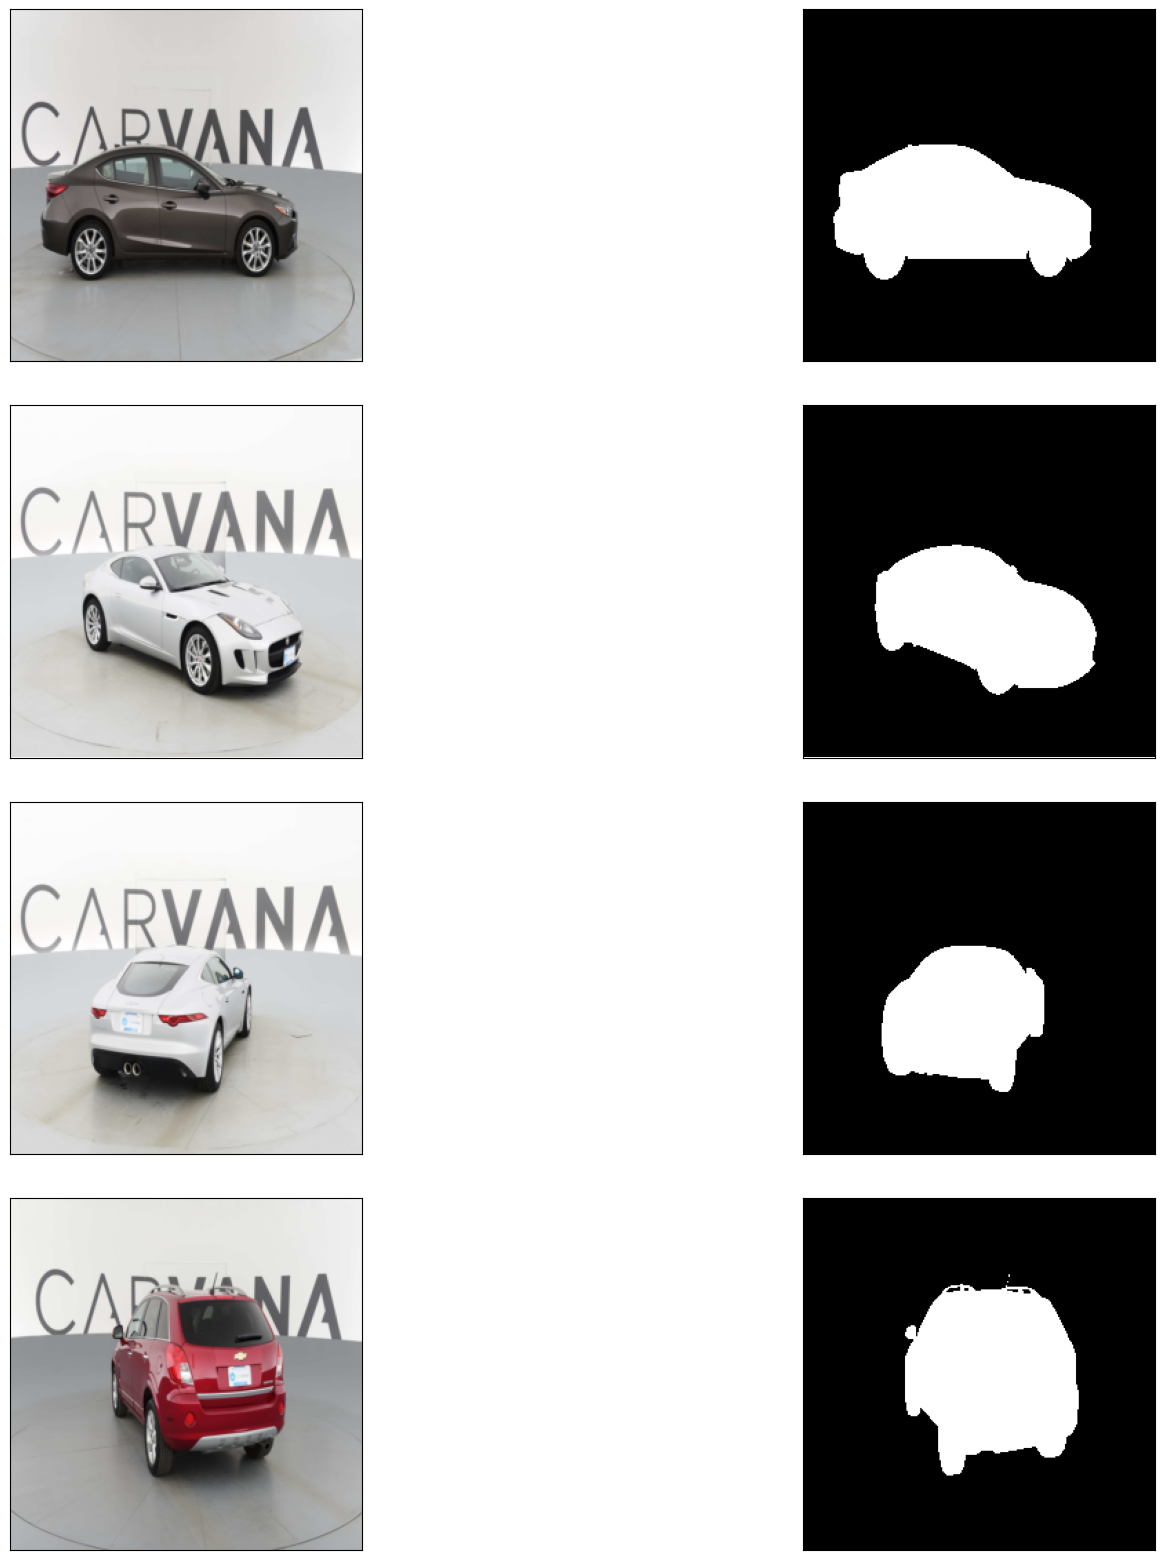

In [ ]:
img_list = []
for i in range(4):
    img, label = train_dataset[np.random.randint(0, 100)]
    img_list.append((img, label))

im_show(img_list)

https://arxiv.org/abs/1511.00561
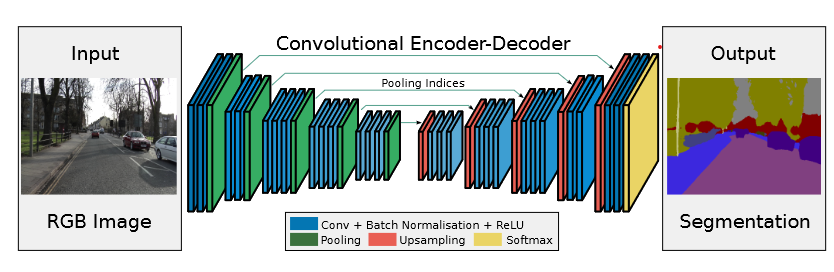

U-net architecture (https://arxiv.org/pdf/1505.04597.pdf)


<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png">


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, padding=1, stride=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_size, out_size, kernel_size, padding=padding, stride=stride
        )
        self.bn = nn.BatchNorm2d(out_size)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class Unet(nn.Module):
    def __init__(self):
        super().__init__()

        self.down_1 = nn.Sequential(
            ConvBlock(3, 16), ConvBlock(16, 32, stride=2, padding=1)
        )

        self.down_2 = nn.Sequential(ConvBlock(32, 64), ConvBlock(64, 128))

        self.middle = ConvBlock(128, 128, kernel_size=1, padding=0)

        self.up_2 = nn.Sequential(ConvBlock(256, 128), ConvBlock(128, 32))

        self.up_1 = nn.Sequential(ConvBlock(64, 64), ConvBlock(64, 32))

        self.output = nn.Sequential(
            ConvBlock(32, 16), ConvBlock(16, 1, kernel_size=1, padding=0), nn.Sigmoid()
        )

    def forward(self, x):
        down1 = self.down_1(x)
        out = F.max_pool2d(down1, kernel_size=2, stride=2)

        down2 = self.down_2(out)
        out = F.max_pool2d(down2, kernel_size=2, stride=2)

        out = self.middle(out)

        out = nn.functional.interpolate(
            out, scale_factor=2
        )  # interpolation increases the size of the feature maps twice
        out = torch.cat([down2, out], 1)
        out = self.up_2(out)

        out = nn.functional.interpolate(out, scale_factor=2)
        out = torch.cat([down1, out], 1)
        out = self.up_1(out)

        out = nn.functional.interpolate(out, scale_factor=2)
        return self.output(out)

In [ ]:
def train(train_loader, model, criterion, epoch, num_epochs, device):
    model.train()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images) # torch.sigmoid(model(images))

        loss = criterion(outputs, labels)

        accuracy = ((outputs > 0.5) == labels).float().mean()

        pbar.set_description(
            f"Loss: {round(loss.item(), 4)} "
            f"Accuracy: {round(accuracy.item() * 100, 4)}"
        )

        loss.backward()
        optimizer.step()

In [ ]:
device = "cuda"
model = Unet().to(device)
criterion = (
    torch.nn.BCELoss()
)  # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
optimizer = torch.optim.RMSprop(
    model.parameters(), weight_decay=1e-4, lr=1e-4, momentum=0.9
)

num_epochs = 1
for epoch in range(0, num_epochs):
    train(train_loader, model, criterion, epoch, num_epochs, device=device)

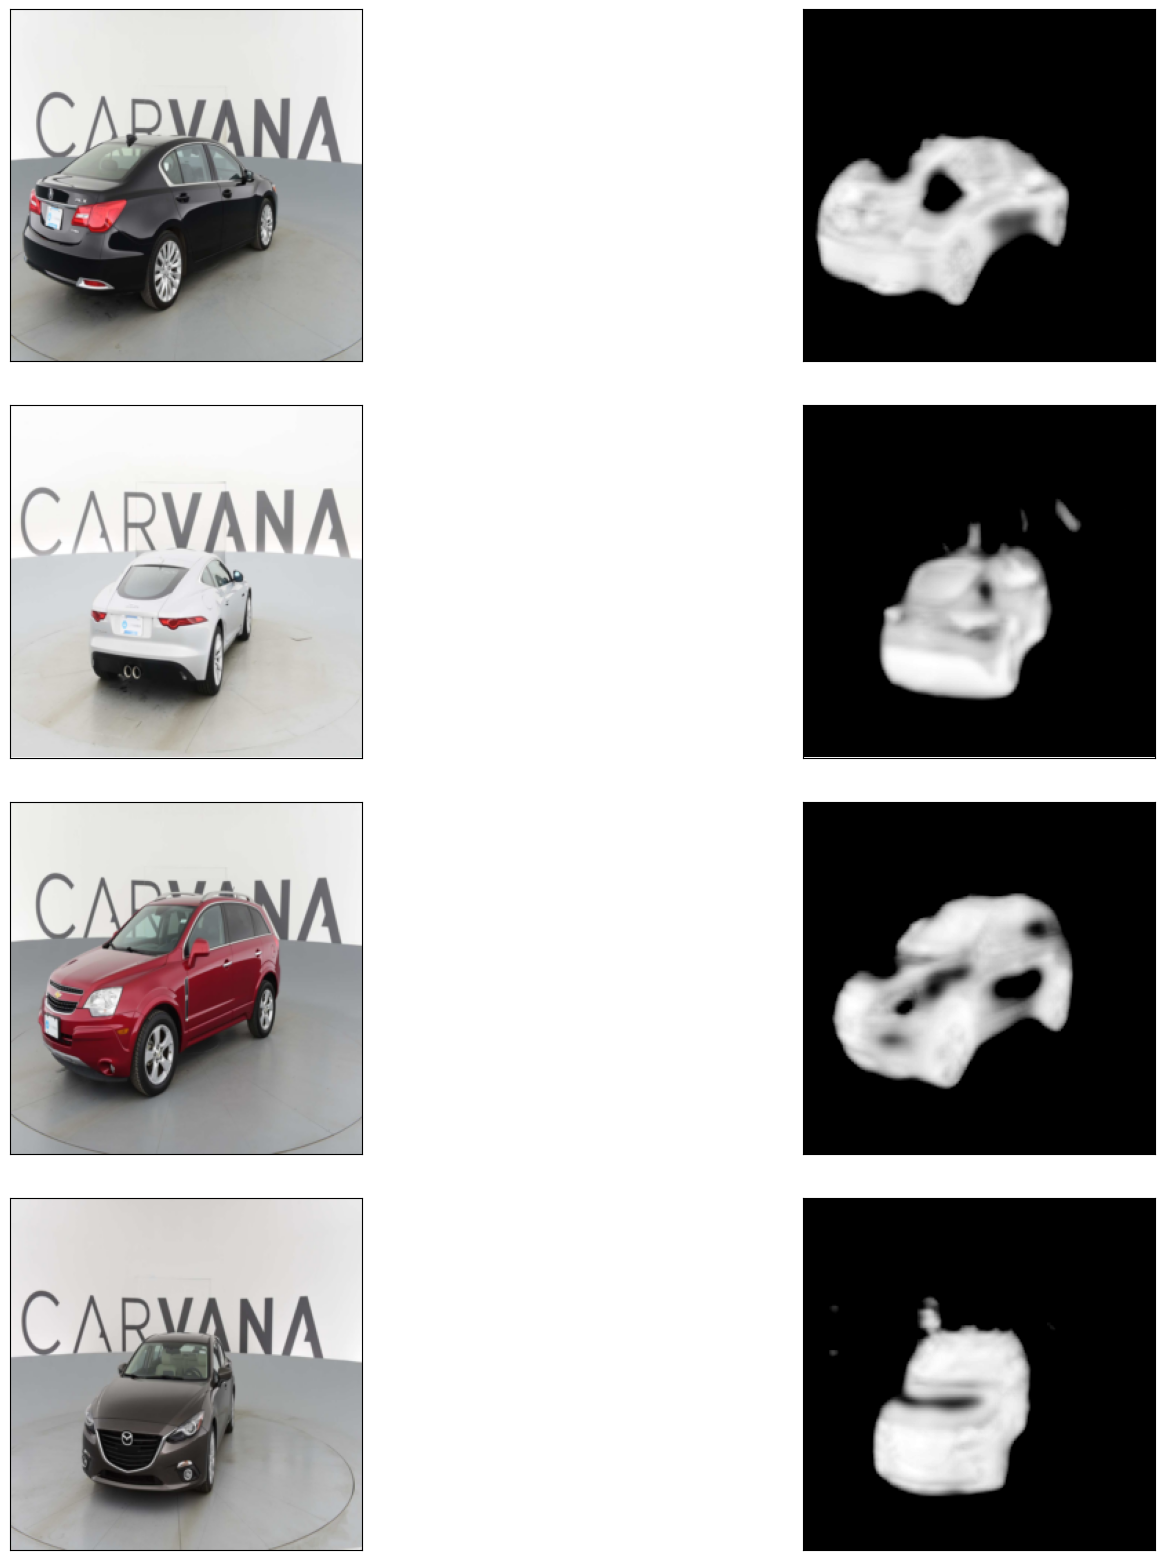

In [ ]:
img_list = []
for i in range(4):
    img, label = train_dataset[np.random.randint(0, 100)]
    pred = model(img.unsqueeze(0).cuda()).detach().squeeze(0).cpu()
    img_list.append((img, pred))

im_show(img_list)

In [ ]:
# clear the memory
torch.cuda.empty_cache()

---

# Mean Average Precision

<br>
$$ Precision = {TP \over TP + FP} $$
<br>
$$ Recall = {TP \over TP + FN} $$
<br>
<br>TP - True Positive
<br>FP - False Positive
<br>FN - False Negative

<h4>Intersection over Union</h4>
<img src=https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png>

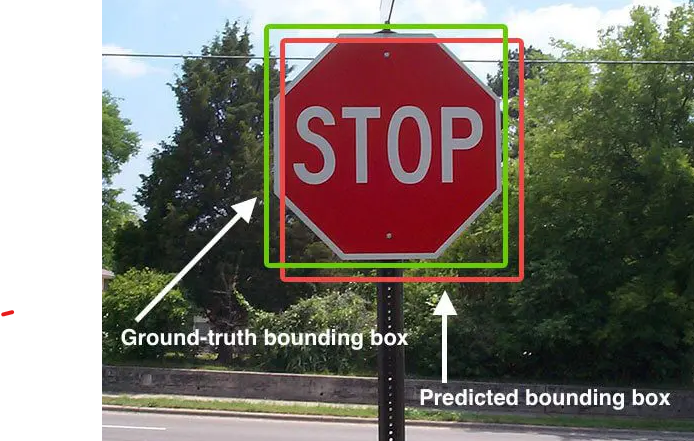

source: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

Usually
-  TP in case IoU > 0.5 and the class is defined correctly
-  FP in case IoU <= 0.5 and/or repeated bounded boxes
-  FN in case IoU > 0.5, but class is wrong, or the absence of the box

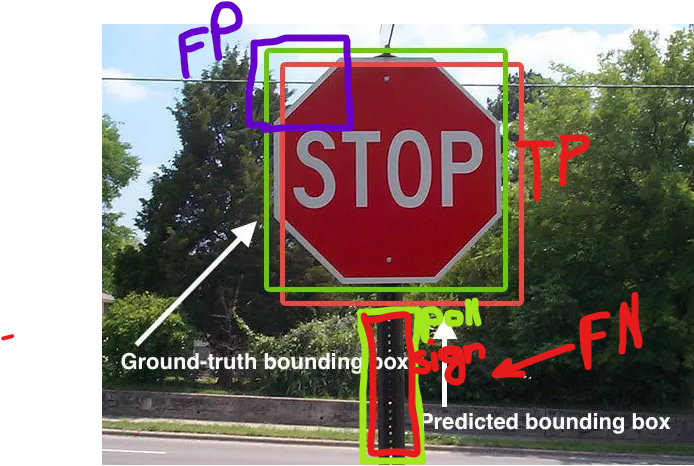


**Average Precision (AP)** is **defined sa AUC-PR**

<h3>mAP</h3>

For <font color="green">PASCAl VOC </font>  contest (2011 - 2012)  **Average Precision** was **area under the monotonous PR curve.**

**Mean Average Precison** is the average of AP over classes:

$$mAP = \frac{1}{C} \sum_{c \in C} AP(c),$$
where $C$ is the set of classes.

---

# 3. Object Detection

We use pre-trained Faster R-CNN model from pytorch and do fine-tuning.

[Penn-Fudan](https://www.cis.upenn.edu/~jshi/ped_html/) dataset contains 170 images with labels for segmentation and detection.

In [ ]:
! curl https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip > PennFudanPed.zip
! unzip -q PennFudanPed.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51.2M  100 51.2M    0     0  57.8M      0 --:--:-- --:--:-- --:--:-- 57.7M


In [ ]:
from PIL import ImageDraw
from sklearn.metrics import auc
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root: str, transforms_list: transforms = None):
        self.root = root
        self.transforms = transforms_list
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")

        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        mask = np.array(mask)

        # instances are encoded as different colors
        obj_ids = np.unique(mask)

        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])

        target = {"boxes": boxes, "labels": labels, "image_id": image_id}

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)


def get_transform(train=False):
    transforms_list = []
    if train:
        transforms.append(transforms.RandomHorizontalFlip(0.5))
    transforms_list.append(transforms.ToTensor())

    return transforms.Compose(transforms_list)

In [ ]:
dataset = PennFudanDataset("PennFudanPed/", get_transform())

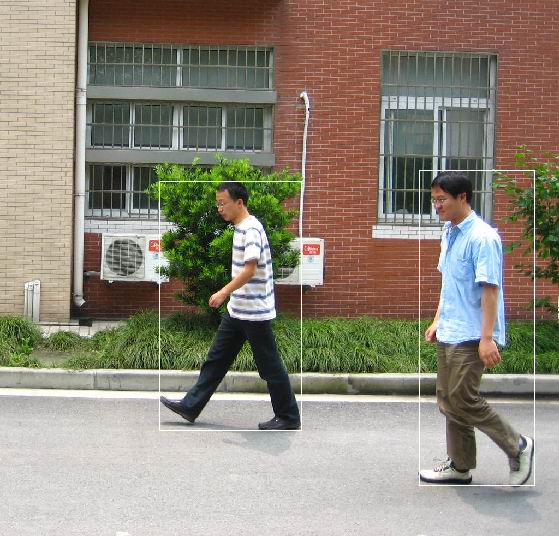

In [ ]:
image, labels = next(iter(dataset))
image = transforms.ToPILImage()(image)

draw = ImageDraw.Draw(image)
for box in labels["boxes"]:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])

image

Upload the model. We have only  2 classes: people and background, so we change the output layer  `FastRCNNPredictor`. Good explanation https://towardsdatascience.com/understanding-and-implementing-faster-r-cnn-a-step-by-step-guide-11acfff216b0

<h4>Fast R-CNN</h4>
<img src=https://pytorch.org/tutorials/_static/img/tv_tutorial/tv_image03.png>

In [ ]:
def get_detection_model(num_classes=2):
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
def intersection_over_union(dt_bbox: np.array, gt_bbox: np.array) -> float:
    """
    Intersection over Union between two bboxes
    (x0, y0) - coordinates of the upper left bbox corner
    (x1, y1) - coordinates of the down right bbox corner

    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """
    # upper left corner
    int_x0 = max(dt_bbox[0], gt_bbox[0])
    int_y0 = max(dt_bbox[1], gt_bbox[1])
    # bottom right corner
    int_x1 = min(dt_bbox[2], gt_bbox[2])
    int_y1 = min(dt_bbox[3], gt_bbox[3])

    intersection = max(int_x1 - int_x0, 0) * max(int_y1 - int_y0, 0)
    dt_area = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    gt_area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    return intersection / (dt_area + gt_area - intersection)

In [ ]:
dt_bbox = [0, 0, 2, 2]
gt_bbox = [1, 1, 3, 3]
intersection_over_union(dt_bbox, gt_bbox)

0.14285714285714285

In [ ]:
def evaluate_sample(target_pred: torch.Tensor, target_true, iou_threshold=0.5):
    # target boxes
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    # predicted boxes
    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    # find the best box by IoU
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            # check IoU >  0.5
            detection_result_dict["TP"] = 1
            # remove
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results

In [ ]:
def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)

            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                # match the predicted boxes with targets
                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    # calculate presision and recall
    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    global_loss = 0
    for images, targets in tqdm(data_loader, leave=False, desc="Batch number"):
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        global_loss += float(losses.cpu().detach().numpy())

    return global_loss


def train(model, train_loader, test_loader, optimizer, device, num_epochs=5):
    for epoch in trange(num_epochs, leave=True, desc=f"Epoch number"):
        train_one_epoch(model, optimizer, train_loader, device)
        mAP = evaluate(model, test_loader, device=device)

        print(f"mAP after epoch {epoch + 1} is {mAP:.3f}")

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))


dataset = PennFudanDataset("PennFudanPed", get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()

dataset_train = torch.utils.data.Subset(dataset, indices[:-50])
data_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=4,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    collate_fn=collate_fn,
)

dataset_test = torch.utils.data.Subset(dataset, indices[-50:])
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn
)

In [ ]:
num_classes = 2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = get_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

train(model, data_loader_train, data_loader_test, optimizer, device, num_epochs=1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 146MB/s]


Epoch number:   0%|          | 0/1 [00:00<?, ?it/s]

Batch number:   0%|          | 0/30 [00:00<?, ?it/s]

mAP after epoch 1 is 0.979


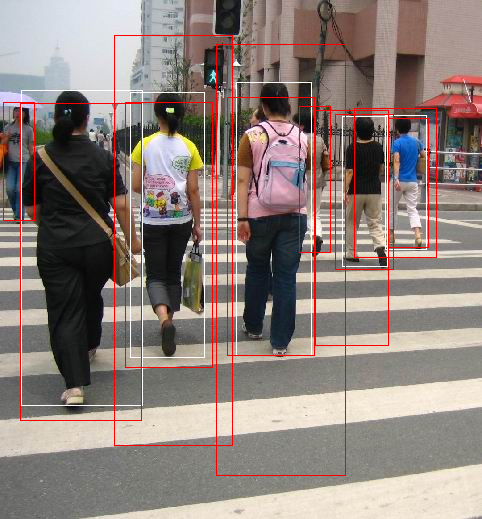

In [ ]:
r = np.random.randint(0,len(dataset_test)-1)
image, labels = dataset_test[r] #next(iter(dataset_test))
model.eval()
pred = model(image.unsqueeze(0).to(device))[0]

image = transforms.ToPILImage()(image)

draw = ImageDraw.Draw(image)

for box in labels["boxes"]:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])

for box in pred["boxes"]:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red")

image

In [ ]:
pred

{'boxes': tensor([[ 40.3116, 126.0702, 176.2840, 494.0000],
         [244.8018, 164.1684, 334.3050, 464.3539],
         [334.3904, 176.2112, 429.3664, 460.9694],
         [428.6311, 159.2523, 500.3246, 396.2719],
         [323.1277, 168.4723, 338.7308, 205.3329],
         [401.8219, 144.6597, 442.8869, 359.4228],
         [259.9617, 159.8914, 474.3231, 432.9045]], device='cuda:0',
        grad_fn=<StackBackward0>),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9980, 0.9969, 0.9968, 0.9783, 0.4252, 0.2824, 0.0967],
        device='cuda:0', grad_fn=<IndexBackward0>)}

In [ ]:
for l_box in labels["boxes"]:
    print(
        intersection_over_union(pred["boxes"][0].cpu().detach().numpy(), l_box.numpy())
    )

0.0
0.0
0.93229717
0.0
